3.1 Random Forests with More Features
---

In order to improve classification accuracy, the remainder of the collected features were incorporated into the dataset, primarily consisting of molecular formula. Given the varying baseline of the considered carbonyl classes, it was expected that improved classification rates should be obtainable with these additional features. For example, both acid and ester groups necessarily contain at least two oxygen atoms, whereas amides necessarily contain one nitrogen, and acid chlorides contain at least one chloride. The interspersion of aldehydes and ketones, however, was expected to remain a challenging distinction given that molecular formula alone cannot dinstiguish between two constitutional isomers.

An 80/20 training/test split was similarly employed with feature normalization applied based on the training set and processed through a random forests classifier as before. Similarly, a confusion matrix showing the results of the 20% test set is plotted, along with a bar graph illustration features importances calculated from the random forest fit.

In [1]:
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import sklearn as sk
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn import preprocessing
import plot_utils

DATA_PATH = "Data/carbonyl.csv"
# Provide dictionary for label codes
LABEL_DICT = {0: 'ketone', 1: 'aldehyde', 2: 'ester', 3: 'amide', 4: 'acid', 5:'acid chloride'}

# Load carbonyl datafile as Pandas dataframe
carb_df = pd.read_csv(DATA_PATH)


### Adding some additional features and feature engineering

See if the classification accuracy increases with more features, specifically, parsed formula

In [2]:
# TODO: need to clean up quick formula parsing implementation
import formulas

list_dict = []
for formula in carb_df['Formula']:
    list_dict.append(formulas.parseFormula(formula))

In [3]:
# Create pandas df
atom_df = pd.DataFrame(list_dict)

In [4]:
# Join DataFrames and fill NaNs with 0's
new_df = carb_df.join(atom_df).fillna(0)

In [5]:
new_df.head()

,Name,CAS,Formula,SMILES,Carbon,Infrared,Label,Br,C,Cl,F,H,N,O,S
0,(+-)-2-chloropropionamide,27816-36-0,C3H6ClNO,CC(C(=O)N)Cl,172.9,1642,3,0.0,3,1.0,0.0,6.0,1.0,1,0.0
1,(+-)-2-methylbutyryl chloride,57526-28-0,C5H9ClO,CCC(C)C(=O)Cl,177.5,1793,5,0.0,5,1.0,0.0,9.0,0.0,1,0.0
2,(+-)-mevalonic acid delta-lactone,674-26-0,C6H10O3,CC1(CCOC(=O)C1)O,171.5,1721,2,0.0,6,0.0,0.0,10.0,0.0,3,0.0
3,(1R)-(-)-myrtenal,564-94-3,C10H14O,CC1(C2CC=C(C1C2)C=O)C,191.3,1679,1,0.0,10,0.0,0.0,14.0,0.0,1,0.0
4,(3-bromophenyl)acetic acid,1878-67-7,C8H7BrO2,C1=CC(=CC(=C1)Br)CC(=O)O,177.3,1698,4,1.0,8,0.0,0.0,7.0,0.0,2,0.0


In [6]:
# Some feature engineering here
new_df['Unsaturation'] = new_df['H']/new_df['C']

In [7]:
new_df.head()

,Name,CAS,Formula,SMILES,Carbon,Infrared,Label,Br,C,Cl,F,H,N,O,S,Unsaturation
0,(+-)-2-chloropropionamide,27816-36-0,C3H6ClNO,CC(C(=O)N)Cl,172.9,1642,3,0.0,3,1.0,0.0,6.0,1.0,1,0.0,2.000000
1,(+-)-2-methylbutyryl chloride,57526-28-0,C5H9ClO,CCC(C)C(=O)Cl,177.5,1793,5,0.0,5,1.0,0.0,9.0,0.0,1,0.0,1.800000
2,(+-)-mevalonic acid delta-lactone,674-26-0,C6H10O3,CC1(CCOC(=O)C1)O,171.5,1721,2,0.0,6,0.0,0.0,10.0,0.0,3,0.0,1.666667
3,(1R)-(-)-myrtenal,564-94-3,C10H14O,CC1(C2CC=C(C1C2)C=O)C,191.3,1679,1,0.0,10,0.0,0.0,14.0,0.0,1,0.0,1.400000
4,(3-bromophenyl)acetic acid,1878-67-7,C8H7BrO2,C1=CC(=CC(=C1)Br)CC(=O)O,177.3,1698,4,1.0,8,0.0,0.0,7.0,0.0,2,0.0,0.875000


In [8]:
features = ['Carbon', 'Infrared', 'C', 'H', 'N', 'O', 'S', 'Cl', 'F', 'Br', 'Unsaturation']

In [11]:
# Create a randomized 80/20 training/test Split
carb_train, carb_test = sk.model_selection.train_test_split(new_df, test_size = 0.2)

# calculate mean normalization w/ unit variance on training set
std_scale = sk.preprocessing.StandardScaler().fit(carb_train[features])

# apply to create standardized training and test sets with labels
train_std = std_scale.transform(carb_train[features])
test_std = std_scale.transform(carb_test[features])
train_labels = np.array(carb_train['Label'])
test_labels = np.array(carb_test['Label'])

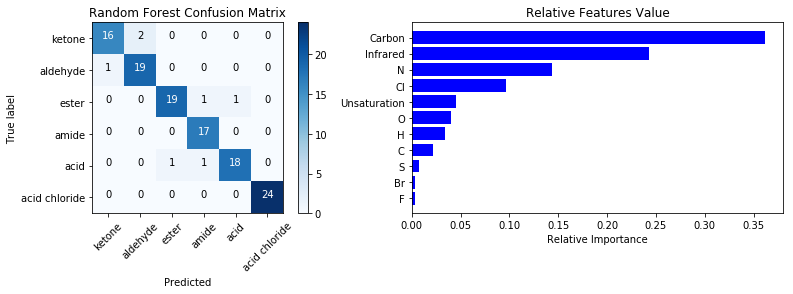

Random Forest Out of Bag (OOB) Score : 0.908
Random Forest Test Set Score : 0.942


In [12]:
# train the RF classifier
forest = RandomForestClassifier(n_jobs=-1, n_estimators=100, oob_score=True, max_features=None)
forest.fit(train_std, train_labels)

# generate predictions and retrieve feature importances
rfc_preds = np.array(forest.predict(test_std))
rf_test_score = forest.score(test_std, test_labels)
importances = forest.feature_importances_
indices = np.argsort(importances)

# plot confusion matrix and relative importance
plt.subplots(1, 2, figsize=(12,4))
plt.subplot(1, 2, 2)
plt.title('Relative Features Value')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.tight_layout()

plt.subplot(1, 2, 1)
rfc_cn = confusion_matrix(test_labels, rfc_preds)
plot_utils.plot_confusion_matrix(rfc_cn, LABEL_DICT.values(), 
                      pltTitle='Random Forest Confusion Matrix')
plt.show()

print("Random Forest Out of Bag (OOB) Score : %.3f" % (forest.oob_score_))
print("Random Forest Test Set Score : %.3f" % (rf_test_score))

Some improvement by including molecular formula.